In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
# Parameters
N = 20  # Size of the matrix
J = 1.0  # Interaction strength
T_values = np.linspace(0.5, 3.0, 20)  # Temperature range
steps = 10000  # Number of Monte Carlo steps
H = 0.0  # External magnetic field (can be varied)

In [4]:

# Initialize the NxN matrix with random +1 and -1
spins = np.random.choice([-1, 1], size=(N, N))


In [5]:
# Function to calculate the energy of the system
def calculate_energy(spins, J, H):
    energy = 0
    for i in range(N):
        for j in range(N):
            # Sum over nearest neighbors (periodic boundary conditions)
            energy -= J * spins[i, j] * (
                spins[(i + 1) % N, j] + spins[(i - 1) % N, j] +
                spins[i, (j + 1) % N] + spins[i, (j - 1) % N]
            )
            # External magnetic field contribution
            energy -= H * spins[i, j]
    return energy / 2  # Divide by 2 to avoid double-counting


In [6]:
# Function to calculate magnetization
def calculate_magnetization(spins):
    return np.mean(spins)


In [7]:
# Function to calculate the spin-spin correlation function
def calculate_correlation(spins, r):
    correlation = 0
    for i in range(N):
        for j in range(N):
            # Periodic boundary conditions
            correlation += spins[i, j] * spins[(i + r) % N, (j + r) % N]
    return correlation / (N * N)


In [8]:
# Function to perform Kawasaki dynamics
def kawasaki_dynamics(spins, J, T, steps, H):
    energy_history = []  # To store energy at each step
    magnetization_history = []  # To store magnetization at each step
    initial_energy = calculate_energy(spins, J, H)
    initial_magnetization = calculate_magnetization(spins)
    energy_history.append(initial_energy/(N*N))
    magnetization_history.append(initial_magnetization)
    
    for step in range(steps):
        # Randomly select two distinct sites
        i1, j1 = np.random.randint(0, N, 2)
        i2, j2 = np.random.randint(0, N, 2)
        
        # Ensure the two sites are different
        if (i1 != i2 or j1 != j2):
            # Calculate the energy change due to the spin exchange
            delta_E = 0
            # Energy contribution from site (i1, j1)
            delta_E += J * spins[i1, j1] * (
                spins[(i1 + 1) % N, j1] + spins[(i1 - 1) % N, j1] +
                spins[i1, (j1 + 1) % N] + spins[i1, (j1 - 1) % N]
            )
            delta_E += H * spins[i1, j1]
            # Energy contribution from site (i2, j2)
            delta_E += J * spins[i2, j2] * (
                spins[(i2 + 1) % N, j2] + spins[(i2 - 1) % N, j2] +
                spins[i2, (j2 + 1) % N] + spins[i2, (j2 - 1) % N]
            )
            delta_E += H * spins[i2, j2]
            # Energy contribution after exchange
            spins[i1, j1], spins[i2, j2] = spins[i2, j2], spins[i1, j1]
            delta_E -= J * spins[i1, j1] * (
                spins[(i1 + 1) % N, j1] + spins[(i1 - 1) % N, j1] +
                spins[i1, (j1 + 1) % N] + spins[i1, (j1 - 1) % N]
            )
            delta_E -= H * spins[i1, j1]
            delta_E -= J * spins[i2, j2] * (
                spins[(i2 + 1) % N, j2] + spins[(i2 - 1) % N, j2] +
                spins[i2, (j2 + 1) % N] + spins[i2, (j2 - 1) % N]
            )
            delta_E -= H * spins[i2, j2]
            
            # Metropolis acceptance criterion
            if delta_E > 0:
                if np.random.rand() > np.exp(-delta_E / T):
                    # Reject the exchange
                    spins[i1, j1], spins[i2, j2] = spins[i2, j2], spins[i1, j1]
            
            # Calculate the new energy and magnetization
            new_energy = calculate_energy(spins, J, H)
            new_magnetization = calculate_magnetization(spins)
            energy_history.append(new_energy/(N*N))
            magnetization_history.append(new_magnetization)
    
    return spins, energy_history, magnetization_history

In [9]:
# Function to calculate specific heat
def calculate_specific_heat(energy_history, T):
    energy_array = np.array(energy_history)
    mean_energy = np.mean(energy_array)
    mean_energy_squared = np.mean(energy_array**2)
    specific_heat = (mean_energy_squared - mean_energy**2) / (T**2)
    return specific_heat

In [10]:
# Function to calculate magnetic susceptibility
def calculate_susceptibility(magnetization_history, T):
    magnetization_array = np.array(magnetization_history)
    mean_magnetization = np.mean(magnetization_array)
    mean_magnetization_squared = np.mean(magnetization_array**2)
    susceptibility = (mean_magnetization_squared - mean_magnetization**2) / T
    return susceptibility

In [11]:
# Function to calculate autocorrelation
def calculate_autocorrelation(data, max_lag):
    autocorr = []
    for lag in range(max_lag):
        autocorr.append(np.corrcoef(data[:-lag], data[lag:])[0, 1])
    return autocorr

In [12]:
# Function to visualize domains
def visualize_domains(spins):
    plt.imshow(spins, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title("Spin Configuration (Domains)")
    plt.show()

In [13]:
# Function to animate spin evolution
def animate_spins(spins_history):
    fig, ax = plt.subplots()
    im = ax.imshow(spins_history[0], cmap='coolwarm', interpolation='none')
    plt.colorbar(im)

    def update(frame):
        im.set_array(spins_history[frame])
        return im,

    ani = FuncAnimation(fig, update, frames=len(spins_history), interval=100, blit=True)
    plt.show()

In [14]:
# Run simulations for different temperatures
specific_heat_values = []
susceptibility_values = []
magnetization_values = []

for T in T_values:
    spins = np.random.choice([-1, 1], size=(N, N))
    final_spins, energy_history, magnetization_history = kawasaki_dynamics(spins, J, T, steps, H)
    specific_heat_values.append(calculate_specific_heat(energy_history, T))
    susceptibility_values.append(calculate_susceptibility(magnetization_history, T))
    magnetization_values.append(np.mean(magnetization_history[-1000:]))  # Average over last 1000 steps


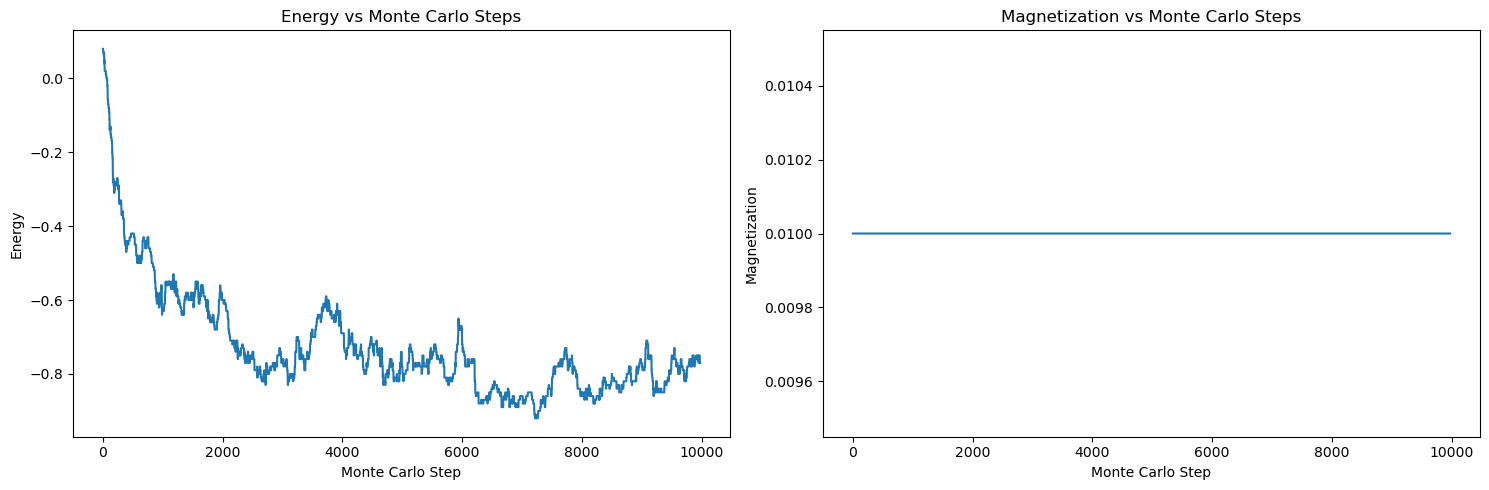

In [17]:
plt.figure(figsize=(15, 5))

# Plot energy
plt.subplot(1, 2, 1)
plt.plot(energy_history)
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.title("Energy vs Monte Carlo Steps")

# Plot magnetization
plt.subplot(1, 2, 2)
plt.plot(magnetization_history)
plt.xlabel("Monte Carlo Step")
plt.ylabel("Magnetization")
plt.title("Magnetization vs Monte Carlo Steps")



plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Magnetization vs Temperature')

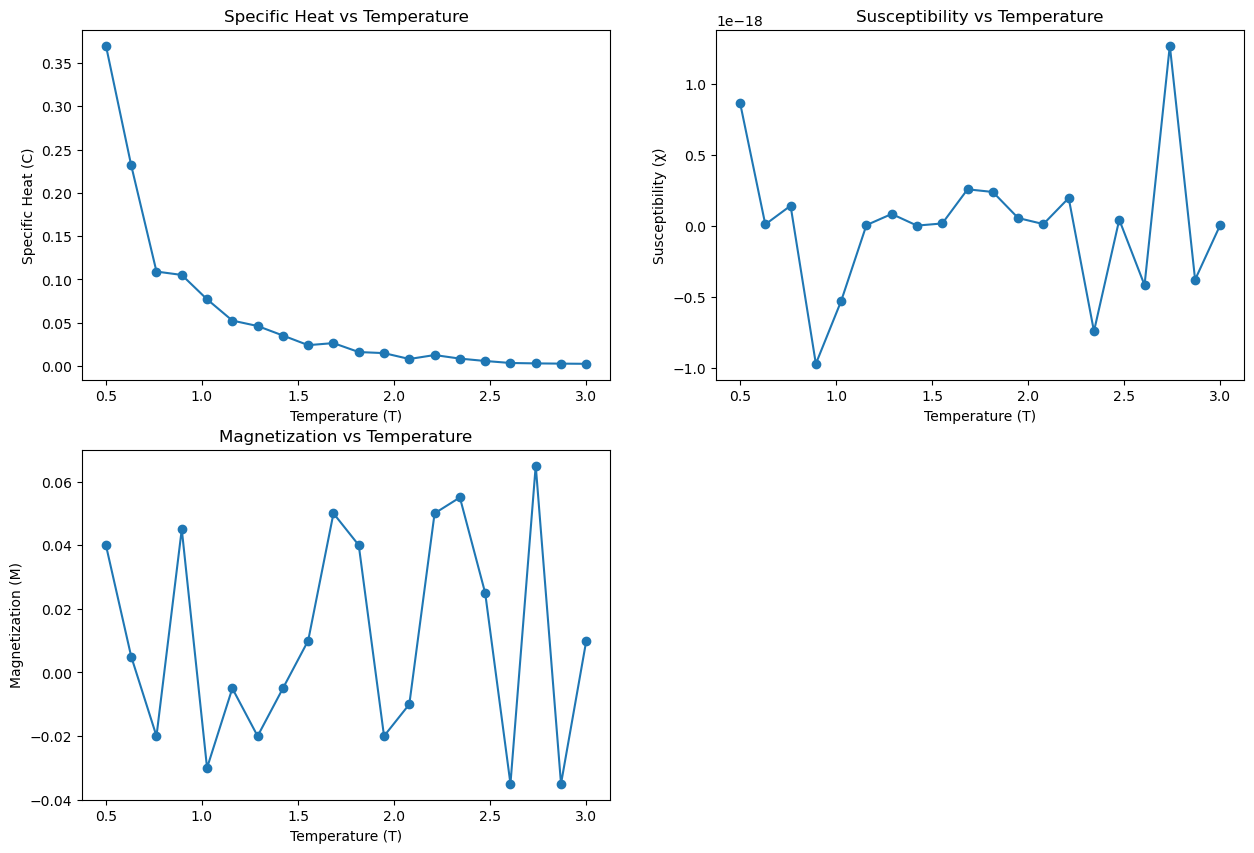

In [15]:
# Plot results
plt.figure(figsize=(15, 10))

# Plot specific heat
plt.subplot(2, 2, 1)
plt.plot(T_values, specific_heat_values, 'o-')
plt.xlabel("Temperature (T)")
plt.ylabel("Specific Heat (C)")
plt.title("Specific Heat vs Temperature")

# Plot susceptibility
plt.subplot(2, 2, 2)
plt.plot(T_values, susceptibility_values, 'o-')
plt.xlabel("Temperature (T)")
plt.ylabel("Susceptibility (χ)")
plt.title("Susceptibility vs Temperature")

# Plot magnetization
plt.subplot(2, 2, 3)
plt.plot(T_values, magnetization_values, 'o-')
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetization (M)")
plt.title("Magnetization vs Temperature")






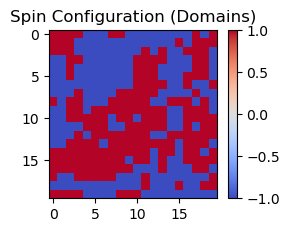

<Figure size 640x480 with 0 Axes>

In [18]:
# Visualize domains
plt.subplot(2, 2, 4)
visualize_domains(final_spins)

plt.tight_layout()
plt.show()


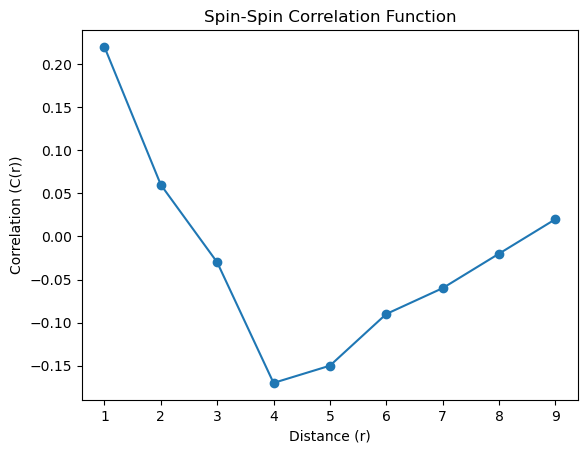

In [19]:
# Calculate and plot correlation function
r_values = range(1, N // 2)
correlation_values = [calculate_correlation(final_spins, r) for r in r_values]
plt.plot(r_values, correlation_values, 'o-')
plt.xlabel("Distance (r)")
plt.ylabel("Correlation (C(r))")
plt.title("Spin-Spin Correlation Function")
plt.show()